# Assignment 7: Transfer Learning


The goal of this exercise is to learn how to use pre-trained networks in transfer learning tasks.
We will make use of networks trained on ImageNet, and apply them to related problems, i.e., the classification of $10$ objects not contained in ImageNet.

## Dataset

For this exercise we use the  [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset that can be downloaded from the official website [here]({https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz}).
The dataset contains $60000$ color images of pixels size $32\times 32$ in $10$ classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship and truck, with $6000$ images per class.

### Task 1: Data Transformation

We need to instantiate a proper `torchvision.transform` instance to create the same input structure as used for training our network.
We need to combine 4 transforms, which can be compiled from the PyTorch website: https://pytorch.org/vision/stable/models.html

1. We need to resize the image such that the shorter side has size 256.
2. We need to take the center crop of size $224\times224$ from the image.
3. We need to convert the image into a tensor (including pixel values scaling)
4. We need to normalize the pixel values with mean $(0.485, 0.456, 0.406)$ and standard deviation $(0.229, 0.224, 0.225)$.

Since we will use networks pre-trained on ImageNet, we need to perform the exact same transform as used for ImageNet testing.

In [41]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchvision.models import resnet101
import torchvision
from tqdm import tqdm

imagenet_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


### Task 2: Dataset Loading

We here use the [torchvision.datasets.CIFAR10](https://pytorch.org/vision/0.12/generated/torchvision.datasets.CIFAR10.html) dataset interface for processing images. 
You can use the `train` argument or flag to distinguish between training and test set.

This task consists of two parts:

1. Create two datasets, one for the training set, one for the test set. Use the transform defined above.
2. Once the datasets are created, create two data loaders, one for training set, one for test set. Use a proper value of the batch-size $B$.

In [42]:
trainset = torchvision.datasets.CIFAR10(
  root = "./data",
  train=True, download=True, transform=imagenet_transform
)

testset = torchvision.datasets.CIFAR10(
  root = "./data",
  train=False, download=True, transform=imagenet_transform
)

Files already downloaded and verified
Files already downloaded and verified


In [43]:
B = 64
trainloader = torch.utils.data.DataLoader(dataset = trainset, batch_size=B)
testloader = torch.utils.data.DataLoader(dataset = testset, batch_size=B)

### Test 1: Data Size and Types

We check that all input images are `torch.tensors` of size $3\times224\times224$ and of type `torch.float` and that all labels are of type `int`.

Note: the sanity check is only performed on the test set.

In [44]:
for x, t in testset:
  assert isinstance(x, torch.Tensor)
  assert isinstance(t, int)
  assert x.shape==(3,224,224)
  assert x.dtype==torch.float

## Deep Feature Extraction

We will use a pre-trained network available in `PyTorch`. 
Particularly, we will use a ResNet-50 architecture, but other architectures can also be tested. 
Fortunately, PyTorch provides simple interfaces to obtain pre-trained models, e.g., using the `torchvision.models.resnet50` interface function.

In order to use the networks in a different dataset, we need to change their outputs. 
There are several possibilities on how to achieve that, and you have the freedom to choose. 

For your reference, the implementation of the `forward` function of ResNet networks (including ResNet-50) can be found here: https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L266

You can also check if other networks perform better, for example, deeper ResNet topologies.
Be aware that the strategy to replace the last fully-connected layer might not work in other network topologies, only in residual networks.

### Task 3: Pre-trained Network Instantiation

Instantiate two pre-trained networks of type ResNet-50.

1. Freeze the feature layers of the first network.

Note: Make use the `old TorchVision Interface` to load your pre-trained network. Here is the link: https://pytorch.org/vision/0.12/models.html 

In [45]:
# instantiate the first pre-trained resnet 50 network
network_1 = torchvision.models.resnet50(pretrained=True)
# Make sure to freeze all the layers of the network.
network_1.requires_grad_(False)

# instantiate the second pre-trained resnet 50 network (optinally)
network_2 = torchvision.models.resnet50(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Task 4: Network Implementation

We want to modify the network such that we extract the logits for the 10 classes from CIFAR-10 from the last fully-connected layer of the network.

Implement a function that:
1. Replaces the current last linear layer of the pre-trained network with a new linear layer that has $O$ units ($O$ represents the number of classes in our dataset).
2. Initialize the weights of the new linear layer using Xavier's method **(Optional)**.

Note: Use `torch.nn.init.xavier_uniform_` function to initialize the weights of the new linear layer.

In [46]:
def replace_last_layer(network, O=10):
  # replace the last linear layer with the new layer
  network.fc = torch.nn.Linear(network.fc.in_features, O)

  # initialize weights xavier uniform
  torch.nn.init.xavier_uniform_(network.fc.weight)
  
  return network

### Test 2: Last layer dimensions

This test ensures that the function return a network having the correct number of input and output units in the last layer.

In [47]:
O = 10
for network in (network_1, network_2):
    new_model = replace_last_layer(network_1, O=O)
    assert new_model.fc.out_features == O
    assert new_model.fc.in_features == 2048

## Network Training
Implement a function that takes all necessary parameters to run a training on a given dataset. 
Select the optimizer to be `torch.optim.SGD` and `torch.nn.CrossEntropyLoss` as the loss function. 
The test set will be used as the validation set.

### Task 5: Training and Evaluation Loop

Implement a training loop over a specific number of epochs (10) with a learning rate of $\eta=0.001$ and momentum of $\mu = 0.9$. 
Make sure that you train on the training data only, and `not` on the validation data.
In each loop, compute and print the training loss, training accuracy, validation loss and validation accuracy. 

In [48]:
def accuracy(Z, T):
  # check if we have binary or categorical classification
  # for binary classification, we will have a two-dimensional target tensor
  if len(T.shape) == 2:
    # binary classification
    # If z is equal or larger than the threshold 0.5, then we predict 1, otherwise 0 
    # we use the .float() function to convert the boolean to a float
    # then we compare the prediction with the target and compute the mean
    
    # ??? our data is binary between 0 and 1, so why do you use 0 as threshold ???
    # So only if we use sigmoid activation function for binary or softmax for multi-class
    # after the last layer, we need to use 0.5 as threshold
    return torch.mean(((Z>=0).float() == T).float())

  else:
    # categorical classification
    # the argmax function returns the index of the maximum value
    # we use the .float() function to convert the boolean to a float
    # then we compare the prediction with the target and compute the mean
    # return torch.mean((torch.argmax(Z, dim=1).float() == T).float())
    
    # Y is the index of the maximum value in Z
    Y = torch.argmax(Z, dim=1)
    return torch.mean((Y == T).float())

In [49]:
def train_eval(network, epochs:int = 10, lr:float = 0.001,  µ:float = 0.9):
    
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(network.parameters(), 
                                lr=lr, 
                                momentum=µ)

    train_loss, train_acc = [], []
    val_loss, val_acc = [], []
    
    # instantiate the correct device
    device = torch.device("cuda")
    network = network.to(device)


    for epoch in tqdm(range(epochs)):
        batch_train_loss, batch_train_acc = [], []
        # train network on training data
        for x,t in trainloader:
        # put data to device
            x, t = x.to(device), t.to(device)
            # train
            optimizer.zero_grad()
            # train on training set
            # ... compute network output on training data
            Z = network(x)
            # ... compute loss from network output and target data
            loss_ = loss(Z, t)
            loss_.backward()
            # ... perform parameter update
            optimizer.step()
            # ... remember loss and accuracy
            batch_train_loss.append(loss_.item())
            batch_train_acc.append(accuracy(Z, t).item())
        
    # careful calculate loss and accuracy averaged over batches
    train_loss.append(sum(batch_train_loss) / len(batch_train_loss))
    # ... compute validation set accuracy
    train_acc.append(sum(batch_train_acc) / len(batch_train_acc))

        
    with torch.no_grad():
        batch_val_loss, batch_val_acc = [], []
        for x,t in testloader:
            # put data to device
            x, t = x.to(device), t.to(device)
            # compute validation loss
            Z = network(x)
            # ... compute loss from network output and target data
            loss_ = loss(Z, t)
            # ... remember loss
            batch_val_loss.append(loss_.item())
            # ... compute validation set accuracy
            batch_val_acc.append(accuracy(Z, t).item())
            
        # careful calculate loss and accuracy averaged over batches
        val_loss.append(sum(batch_val_loss) / len(batch_val_loss))
        # ... compute validation set accuracy
        val_acc.append(sum(batch_val_acc) / len(batch_val_acc))


    # return loss and accuracy values
    return train_loss, train_acc, val_loss, val_acc

### Task 6: Network Fine-Tuning with Frozen Layers

Create a network that has feature layers frozen with $10$ output units. 
Fine-tune the created network on our CIFAR-10 data using the previous function.

In [50]:
network_with_frozen_layers = replace_last_layer(network_1, O=O)
train_eval(network = network_with_frozen_layers, epochs=10, lr=0.001, µ=0.9)

100%|██████████| 10/10 [25:01<00:00, 150.20s/it]


([0.6123228761012597],
 [0.7928588554987213],
 [0.6514452972989173],
 [0.7741839171974523])

### Task 7 (Optional): Network Fine-Tuning without Frozen Layers 

Create a network from the second pre-trained network with $10$ output units. 
Fine-tune the created network on our CIFAR-10.

Note:

  * The fine-tuning of the network can take a long time when the layers are not frozen.

In [51]:
network_normal = replace_last_layer(network_2, O=O)
train_eval(network = network_normal, epochs=10, lr=0.001, µ=0.9)

100%|██████████| 10/10 [41:22<00:00, 248.27s/it]


([0.0006658388263582552], [1.0], [0.2124734493743652], [0.9460589171974523])

## Plotting

Finally, we want to plot the confusion matrix of the test set.
For this, we need to compute the predictions for all of our test samples, and the list of target values.
Finally, we can make use of the `sklearn.metrics.confusion_matrix` to compute the confusion matrix.
You can utilize `sklearn.metrics.ConfusionMatrixDisplay` for displaying the confusion matrix, or `pyplot.imshow` and adding the according labels.

Note:

  * The documentation for the confusion matrix can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
  * The interface and an example for the `ConfusionMatrixDisplay` can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

### Task 8: Confusion Matrix Plotting

Plot the confusion matrix for the fine-tuned network with frozen layers.
Optionally, also plot the confusion matrix for the second fine-tuned network.

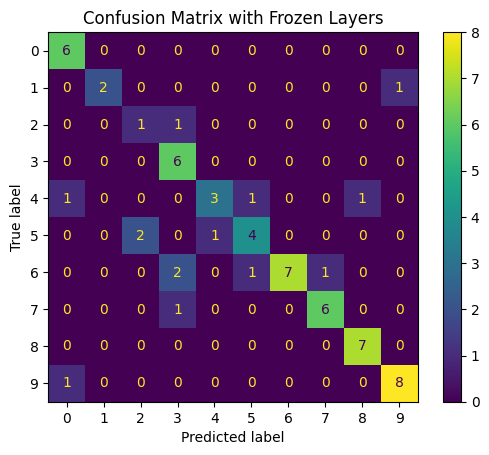

Ellipsis

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

device = torch.device("cuda")

# compute predictions and collect targets
for batch_idx, (x, t) in enumerate(testloader):
    # put data to device
    x, t = x.to(device), t.to(device)
    # compute predictions
    Z = network_with_frozen_layers(x)
    # collect targets
    targets = t.cpu()
    predictions = torch.argmax(Z, dim=1).cpu()
    break
    
# compute confusion matrix
matrix = confusion_matrix(targets, predictions)

# plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=range(10))
disp.plot()
plt.title("Confusion Matrix with Frozen Layers")
plt.show()

# add axis labels if required
...

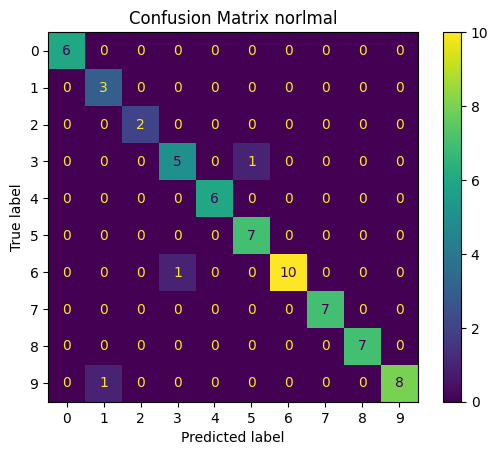

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

device = torch.device("cuda")

# compute predictions and collect targets
for batch_idx, (x, t) in enumerate(testloader):
    # put data to device
    x, t = x.to(device), t.to(device)
    # compute predictions
    Z = network_normal(x)
    # collect targets
    targets = t.cpu()
    predictions = torch.argmax(Z, dim=1).cpu()
    break
    
# compute confusion matrix
matrix = confusion_matrix(targets, predictions)

# plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=range(10))
disp.plot()
plt.title("Confusion Matrix norlmal")
plt.show()
